In [ ]:
#Necessary imports
import numpy as np
import pandas as pd
import os

#For Preprocessing
import cv2
import itertools
from tqdm import tqdm_notebook as tqdm

#Additional imports for functionality
from sklearn.utils import class_weight, shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#For Graphing and Plotting Images
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

#For model building
#import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D 

#from keras import applications
#from keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [ ]:
#acquiring folders that contains specific class of animals
folders= os.listdir('/content/drive/MyDrive/Animals')
#print(folders)

#Creating Empty lists for categories and the files
categories = []
files = []
i = 0

# USED FILE CONTENTS OF SELECT FOLDERS FROM THIS PROVIDED DATASET
#https://www.kaggle.com/alessiocorrado99/animals10


#Going over all the folders and their categories in the foldernames
for k, folder in enumerate(folders):
    #Getting the filenames
    filename = os.listdir("/content/drive/MyDrive/Animals/" + folder);
    for file in filename:
        #Appending all the image files into one list
        files.append("/content/drive/MyDrive/Animals/" + folder + "/" + file)
        #Appending categories into one list
        categories.append(k)


df = pd.DataFrame({
    'filename': files,
    'category': categories
})

df_train = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    df_train = df_train.append(df[df.category == i].iloc[:300,:])

In [ ]:
df_train.head()
df_train = df_train.reset_index(drop=True)
df_train

,filename,category
0,/content/drive/MyDrive/Animals/cat/1812.jpeg,0
1,/content/drive/MyDrive/Animals/cat/271.jpeg,0
2,/content/drive/MyDrive/Animals/cat/1645.jpeg,0
3,/content/drive/MyDrive/Animals/cat/1813.jpeg,0
4,/content/drive/MyDrive/Animals/cat/1710.jpeg,0
...,...,...
895,/content/drive/MyDrive/Animals/butterfly/e030b...,2
896,/content/drive/MyDrive/Animals/butterfly/OIP-v...,2
897,/content/drive/MyDrive/Animals/butterfly/OIP-r...,2
898,/content/drive/MyDrive/Animals/butterfly/OIP-_...,2


In [ ]:
#Assigning x and y to be the values and their target labels respectively
y = df_train['category']
x = df_train['filename']

#Shuffling the data
x, y = shuffle(x, y, random_state=25)

In [ ]:
#Data Preprocessing Work

def centering_image(img):
    size = [256,256]  #may readjust the size if data load is too much
    img_size = img.shape[:2]
    
    #Finding the centre of the image by calculating horizontal
    #and vertical distances
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resize = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resize[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resize

In [ ]:
images = []
#tqdm is used for visualing the progress of the image preprocessing as a progress bar
with tqdm(total=len(df_train)) as pbar:
    #Going over all the filenames in train_df
    for i, file_path in enumerate(df_train.filename.values):
        #Read image using imread
        img = cv2.imread(file_path)

        #Note: Will experiment RGB if possible with current tech limitations
        #Converting IMAGES Colors BWG to RGB
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) COLOR_BGR2GRAY
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #Centering all the images as precaution
        #since image misalignment may cause issues
        img = cv2.resize(img, dsize=(256, 256))

        #We have to shape the output to 224x224px 
        #the VGG-16 model takes in input shape of 224x224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/900 [00:00<?, ?it/s]

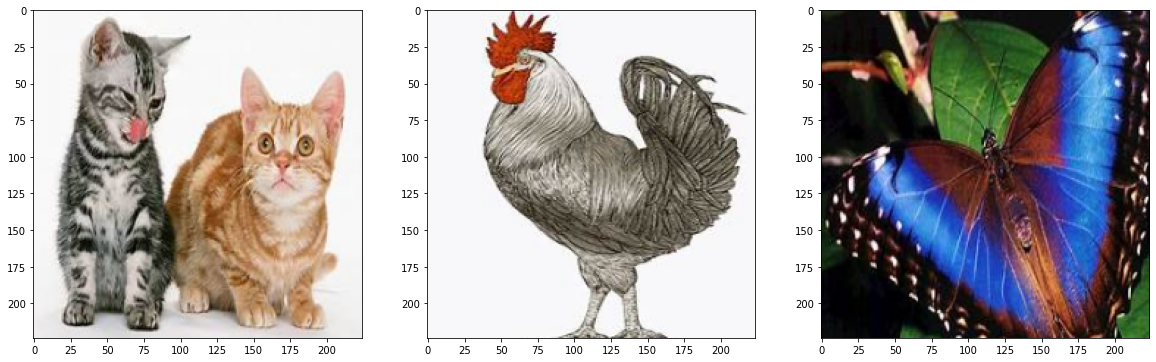

In [ ]:
#10 images one for each category
cols = 3
fig, axes = plt.subplots(ncols=cols, figsize=(20,20))

#Going over each category
for i in range(3):
    #Getting path for each category
    path = df_train[df_train.category == i].values[1]
    #i//cols,
    axes[ i%cols].imshow(images[df_train[df_train.filename == path[0]].index[0]], cmap="gray")

In [ ]:
d_num = len(y)
random_index = np.random.permutation(d_num)

x_raffle = []
y_raffle = []

#shuffle and disperse the data 
for i in range(d_num):
    x_raffle.append(images[random_index[i]])
    y_raffle.append(y[random_index[i]])

x = np.array(x_raffle)
y = np.array(y_raffle)

#80-20 train-test split
test_split = int(round(0.2*len(y)))
x_train = x[test_split:]
y_train = y[test_split:]
x_test = x[:test_split]
y_test = y[:test_split]

#checking to see if the split was done correctly
#print(len(x_train), len(x_test))
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (720, 224, 224, 3)
y_train: (720,)
x_test: (180, 224, 224, 3)
y_test: (180,)


In [ ]:
#Converting categories into binary matrix of 0s and 1s 
#1 - correct class
#0 - Incorrect class in the rest of the places
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#covert the pixel values to float for Grayscale
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#format pizel values to ensure its between 1 and 0
x_train /= 255
x_test /= 255


In [ ]:
#path = df_train[df_train.category == 0].values[2]
#print(path)
#print(path[0].split('/')[5])

animal_name = ['cat', 'chicken', 'butterfly']
img_rows, img_cols, img_chan = 224, 224, 3

#Grayscale has 1 channel where RGB has 3
#alter if doing color

In [ ]:
#Altered Code from previous class to test 
#how my ML models should be structurally established

def vanilla_cnn():
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_chan))

  model = Sequential()
  model.add(Conv2D(filters = 32,kernel_size = (3, 3),padding="same", activation="relu", input_shape=(img_rows, img_cols, img_chan)))
  model.add(MaxPooling2D(3,3))

  model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation="relu"))
  model.add(MaxPooling2D(3,3))

  model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding="same", activation="relu"))
  model.add(MaxPooling2D(3,3))
  model.add(Dropout(0.4))

  model.add(Flatten(input_shape=base_model.output_shape[1:]))
  model.add(Dense(128,activation="relu"))
  model.add(Dense(3, activation="softmax"))
  return model

In [ ]:
batch_size = 32
epochs = 20

    # Compiles a neural network.
    # model: the network to be compiled.
    # optimizer: the optimizer to use.
    # loss: the loss to use.
    # metrics: a list of keras metrics.

#Data Augmentation
def compile_model(model, optimizer = Adam(learning_rate=1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"]): 

    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

model_1 = compile_model(vanilla_cnn())
# model_2 = compile_model(cnn_dropout())
# model_3 = compile_model(cnn_batch_normalized())

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [ ]:
history = model_1.fit(x_train,y_train,epochs = 20 , validation_data = (x_test, y_test))


Epoch 1/20
23/23 [==============================] - 36s 1s/step - loss: 0.9923 - accuracy: 0.4819 - val_loss: 0.9802 - val_accuracy: 0.5278
Epoch 2/20
23/23 [==============================] - 21s 932ms/step - loss: 0.8500 - accuracy: 0.6083 - val_loss: 0.9091 - val_accuracy: 0.5722
Epoch 3/20
23/23 [==============================] - 21s 928ms/step - loss: 0.6993 - accuracy: 0.7250 - val_loss: 0.8582 - val_accuracy: 0.6333
Epoch 4/20
23/23 [==============================] - 22s 938ms/step - loss: 0.6360 - accuracy: 0.7472 - val_loss: 0.8923 - val_accuracy: 0.6722
Epoch 5/20
23/23 [==============================] - 24s 1s/step - loss: 0.6118 - accuracy: 0.7583 - val_loss: 1.0474 - val_accuracy: 0.5778
Epoch 6/20
23/23 [==============================] - 21s 934ms/step - loss: 0.5414 - accuracy: 0.7819 - val_loss: 0.7983 - val_accuracy: 0.6667
Epoch 7/20
23/23 [==============================] - 21s 936ms/step - loss: 0.5233 - accuracy: 0.8056 - val_loss: 0.6949 - val_accuracy: 0.7722
Epoch

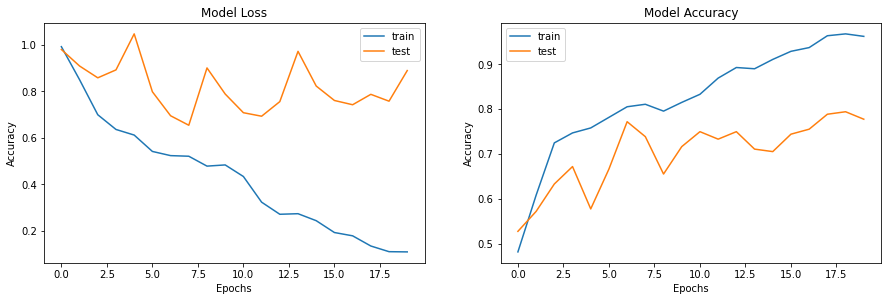

In [ ]:
import matplotlib.gridspec as gridspec

fig = plt.figure()
fig.set_size_inches(15, 15)
gs = gridspec.GridSpec(3, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
plt.title('Model Loss')
ax1.set_ylabel('Loss')

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
ax2.set_ylabel('Accuracy')

ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend(['train', 'test'])

ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')
ax2.legend(['train', 'test'])

plt.show()


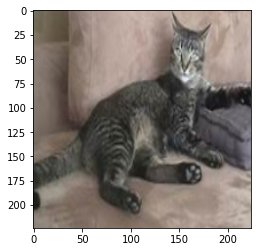

Actual  : cat
Predict : cat


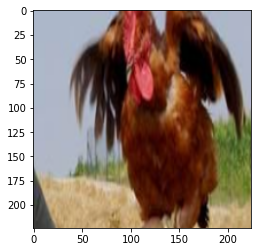

Actual  : chicken
Predict : butterfly


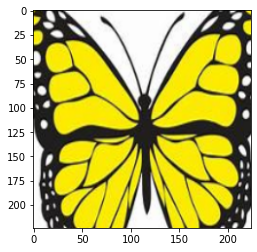

Actual  : butterfly
Predict : butterfly


In [ ]:
import random

test_images = []

j = random.randint(0,299)

#Getting one image from each category for testing
for i in range(3):
    #Getting File Path
    path = df_train[df_train.category == i].values[j]
    #Getting Image from File
    a = images[df_train[df_train.filename == path[0]].index[0]]
    #Converting image into pixel array
    img = np.array(a)
    
    #Preprocessing images using opencv
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = centering_image(cv2.resize(img, dsize=(256, 256)))
    
    #Reshaping into 224x224psx for VGG-16 model 
    img = img[16:240, 16:240]
    test_images.append(img)

test_images = np.array(test_images).reshape(-1,224,224,3)

#Making predictions on test_images
predictions = model_1.predict(test_images)
animals = animal_name

#Plotting predictions
i = 0
for pred in predictions:
    path = df_train[df_train.category == i].values[2]
    plt.imshow(test_images[i])
    plt.show()
    print('Actual  :', animals[i])
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    i += 1